## Introduction

The aim of this notebook is to explore the theoretical situation where a vaccine for covid-19 has been developed and is ready to be distributed across the UK. 

We are in possession of a data sample which gives the locations of several pharmacies in the Nottingham area, which we will use as a case study for our analysis. 

There are two main things we will attempt to do:

- Determine the population served by each of the pharmacies in our sample
- Determine which areas of Nottingham may need special attention based on demographics

If we can accomplish these two things we would be able to, theoretically, determine how to distribute vaccines over this area, and ultimately apply the same logic to the rest of the UK.

## Import Packages

We'll import all the packages we are going to use up front

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ks_2samp
from scipy.stats import contingency as cont
import geopandas 
import geopy.distance
import statistics
import itertools
import os
from datetime import datetime
import matplotlib as mpl
from shapely import wkt
import urllib

import warnings
warnings.filterwarnings('ignore')

## Population served by each pharmacy 

The first thing we want to know is how many people are likely to attend each pharmacy to be administered their vaccine. There are several things we don't know which make this difficult, for example:

- We don't know whether our sample includes all pharmacies in the area (in fact it doesn't)
- We don't know how many other options there will be for immunization (hospitals/doctors etc)
- We don't know whether or not people will attend their nearest pharmacy if given the choice
- We don't know anything about government policy or what percentage of the population will be initially targeted for vaccination 

Therefore, what we will do is simply work out the nearest pharmacy for each person in the Nottingham area and assume that the proportions will be roughly equivalent regardless of the actual numbers. 

### The Data

This is the data we have available in order to accomplish this task

#### Pharmacy Locations

In [17]:
notts_data = pd.read_csv('new_boots_stores_data.csv')

In [18]:
notts_data.head()

,SQ_METRES,ADDRESS_COUNTY,ADDRESS_POST_CODE,TRADING_FORMAT,postcode_no_space,lsoa11nm,lat,long
0,84,Nottinghamshire,NG3 5QS,Pharmacy,NG35QS,Gedling 010B,52.98482,-1.12023
1,85,Nottinghamshire,NG16 3NP,Pharmacy,NG163NP,Broxtowe 002C,53.01744,-1.30387
2,101,Nottinghamshire,NG15 7AX,Pharmacy,NG157AX,Ashfield 014D,53.03844,-1.20346
3,157,Nottinghamshire,NG11 8AA,Pharmacy,NG118AA,Nottingham 035F,52.90328,-1.17783
4,273,Nottinghamshire,NG5 2FS,Pharmacy,NG52FS,Nottingham 010C,52.98140,-1.14587


In [19]:
notts_data.shape

(24, 8)

We have data for twenty-four pharmacies in Nottingham, with their postcodes and coordinates. (This data hasn't been made available, but could easily be substituted with any location based data).

#### LSOA Locations

In [3]:
lsoa_data = pd.read_csv('LSOA_Centroid_Lat_long.csv')

In [4]:
lsoa_data.head()

,Unnamed: 0,LSOA11CD,LSOA11NM,lat,long
0,0,E01030056,Mid Suffolk 006B,52.22901,0.95921
1,1,E01030057,Mid Suffolk 007B,52.16979,1.16698
2,2,E01030054,Mid Suffolk 002B,52.33789,1.04643
3,3,E01030055,Mid Suffolk 002C,52.31135,1.07413
4,4,E01030052,Mid Suffolk 001A,52.31714,1.15737


In [5]:
lsoa_data.shape

(34753, 5)

This data lists every LSOA in England/wales along with the coordinates of its centroid. We can use this information to calculate the nearest pharmacy for each LSOA (bearing in mind that there may be fringe occasions where some residents of an LSOA will not be assigned to their nearest pharmacy because the centroid is not representative of their actual location within the Nottingham area).

#### Population data

Here we'll call out database via API

In [81]:
with urllib.request.urlopen("https://iqapi.azurewebsites.net/api/UkAgeBylandLsoa") as url:
    data = json.loads(url.read().decode())
pop_data = pd.DataFrame(data['results'])

In [82]:
pop_data.head()

,LSOA,Area_Codes,LA__2019_boundaries_,All_Ages,C0,C1,C2,C3,C4,C5,...,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90_
0,None,E06000047,County Durham,526980,4989,5252,5448,5547,5785,5939,...,3312,2843,2659,2341,2063,1811,1741,1409,1149,4138
1,County Durham 001A,E01020634,None,1665,22,12,14,16,17,22,...,17,7,5,11,4,8,3,3,7,9
2,County Durham 001B,E01020635,None,1364,19,13,13,27,11,17,...,8,8,7,3,8,5,6,5,7,8
3,County Durham 001C,E01020636,None,1730,18,21,10,22,20,19,...,13,8,13,6,5,9,4,3,3,15
4,County Durham 001D,E01020654,None,1830,11,13,20,16,21,15,...,9,18,9,8,10,17,10,11,10,37


In [83]:
pop_data.shape

(35092, 95)

This data contains the population (All Ages) of every LSOA (And Local Authority) in England/Wales as well as a breakdown by age (which we'll use later on). 

Now we have all the pieces we need to be able to obtain an estimate for the population served by each pharmacy.

### Merge Tables

First we'll join the LSOA location and population tables. 

We'll do a left join on the locations table to remove all the local authority data which we don't currently need, and we'll only retain the population (All Ages) column.

In [12]:
lsoa_full_data = lsoa_data.merge(pop_data[['Area_Codes', 'All_Ages']], left_on = 'LSOA11CD', 
                                 right_on = 'Area_Codes', how='left').drop(['Unnamed: 0','LSOA11CD'] , axis=1)

In [13]:
lsoa_full_data.head()

,LSOA11NM,lat,long,Area_Codes,All_Ages
0,Mid Suffolk 006B,52.22901,0.95921,E01030056,2257
1,Mid Suffolk 007B,52.16979,1.16698,E01030057,2370
2,Mid Suffolk 002B,52.33789,1.04643,E01030054,1470
3,Mid Suffolk 002C,52.31135,1.07413,E01030055,1424
4,Mid Suffolk 001A,52.31714,1.15737,E01030052,2347


### Determine Nearest Pharmacy

First we need to filter out just the LSOAs in the Nottingham area.

In [14]:
lsoa_notts = lsoa_full_data[lsoa_full_data['LSOA11NM'].str.contains('Nottingham|Ashfield|Gedling|Broxtowe')]

In [15]:
lsoa_notts.head()

,LSOA11NM,lat,long,Area_Codes,All_Ages
55,Broxtowe 014A,52.91457,-1.22443,E01028069,1207
555,Gedling 004C,53.01001,-1.12064,E01028206,1485
560,Gedling 004D,53.01647,-1.11850,E01028207,1613
563,Gedling 010F,52.98223,-1.09970,E01028204,1279
565,Gedling 004B,53.01857,-1.12673,E01028205,1723


Now we can use the coordinates to work out which of our twenty-four sample pharmacies is the closest for each LSOA. 

We'll use the geopy package to determine the distance between our coordinates, and create a new column for our table to indicate the nearest pharmacy (using its postcode as an identifier).

In [20]:
nearest_list = []
for index, row in lsoa_notts.iterrows():
    distance_list = []
    for i, r in notts_data.iterrows():
        store = r['ADDRESS_POST_CODE']
        distance_from = geopy.distance.distance((row['lat'], row['long']), (r['lat'], r['long'])).km
        distance_list.append([store, distance_from])
    temp_list = [x[1] for x in distance_list]
    nearest_list.append(distance_list[temp_list.index(min(temp_list))][0])

In [21]:
lsoa_notts['Nearest_Pharmacy'] = nearest_list

In [22]:
lsoa_notts.head()

,LSOA11NM,lat,long,Area_Codes,All_Ages,Nearest_Pharmacy
55,Broxtowe 014A,52.91457,-1.22443,E01028069,1207,NG9 1GA
555,Gedling 004C,53.01001,-1.12064,E01028206,1485,NG5 5PA
560,Gedling 004D,53.01647,-1.11850,E01028207,1613,NG5 5PA
563,Gedling 010F,52.98223,-1.09970,E01028204,1279,NG3 5QS
565,Gedling 004B,53.01857,-1.12673,E01028205,1723,NG5 5PA


### Group by Pharmacy

Now all we need to do is group our data by the nearest pharmacy to find out its associated population.

In [24]:
pharmacy_pop = lsoa_notts[['All_Ages', 'Nearest_Pharmacy']].groupby('Nearest_Pharmacy').sum().rename(columns={'All_Ages':'Population'})

In [25]:
pharmacy_pop.sort_values('Population', ascending=False).head()

,Population
Nearest_Pharmacy,
NG17 7BG,86970
NG7 5HY,56601
NG4 3BP,51503
NG7 2DW,49212
NG5 5PA,45451


Here we can see the five pharmacies which serve the largest theoretical population

In [26]:
pharmacy_pop.sort_values('Population', ascending=False).tail()

,Population
Nearest_Pharmacy,
NG8 4PN,15179
NG14 6FP,10517
NG6 8AQ,10079
NG16 3GS,9811
NG14 5DX,6195


And here are the five which serve the smallest

### Visualisation

It's quite difficult to get a good idea of our findings just by looking at the tables, so we'll create a plot to better understand what we've discovered.

We'll plot the Nottingham area as a map with the pharmacies overlaid, and then add a bubble to represent the population each pharmacy serves. (To make this plot I've used the goepandas package in conjunction with a shape file of the UK LSOAs which can be found here: (shapefile))

#### Pharmacy geo representation

In [27]:
plot_data = pd.read_csv('new_store_locations_scaled_to_shp_6_7.csv')

In [28]:
plot_data.head()

,Unnamed: 0,SQ_METRES,ADDRESS_COUNTY,ADDRESS_POST_CODE,TRADING_FORMAT,postcode_no_space,lsoa11nm,lat,long,geometry
0,0,84,Nottinghamshire,NG3 5QS,Pharmacy,NG35QS,Gedling 010B,52.98482,-1.12023,POINT (459160.7374227893 343415.2426692739)
1,1,85,Nottinghamshire,NG16 3NP,Pharmacy,NG163NP,Broxtowe 002C,53.01744,-1.30387,POINT (446797.0239058792 346908.6423767042)
2,2,101,Nottinghamshire,NG15 7AX,Pharmacy,NG157AX,Ashfield 014D,53.03844,-1.20346,POINT (453506.9626736775 349314.8057110949)
3,3,157,Nottinghamshire,NG11 8AA,Pharmacy,NG118AA,Nottingham 035F,52.90328,-1.17783,POINT (455397.6733219172 334298.8149684837)
4,4,273,Nottinghamshire,NG5 2FS,Pharmacy,NG52FS,Nottingham 010C,52.98140,-1.14587,POINT (457443.9544898525 343014.0055096669)


This is a dataset I've prepared earlier. It contains the same information as our previous pharmacy sample but with the geopandas geometric representation included as a column so that I can plot every pharmacy as a point on the map we are about to create.

(To create this geometry column I had to convert the lat/long coordinates because geopandas doesn't use traditional lat/long values but a different coordinates system (CRS). Here is a link to a stack overflow page that explains how this is done: https://stackoverflow.com/questions/38961816/geopandas-set-crs-on-points)

We'll merge this data with the population values we have just obtained above.

In [29]:
new_plot_data = pharmacy_pop.reset_index().merge(plot_data[['ADDRESS_POST_CODE', 'geometry']], 
                                                left_on = 'Nearest_Pharmacy', right_on = 'ADDRESS_POST_CODE',
                                                how='left').drop('ADDRESS_POST_CODE', axis=1)

In [30]:
new_plot_data.head()

,Nearest_Pharmacy,Population,geometry
0,NG11 8AA,26443,POINT (455397.6733219172 334298.8149684837)
1,NG14 5DX,6195,POINT (464677.771865485 343836.4995463976)
2,NG14 6FP,10517,POINT (461660.0915230775 349273.188971794)
3,NG15 7AX,17431,POINT (453506.9626736775 349314.8057110949)
4,NG15 7JE,24908,POINT (453331.0336374114 348972.4105054599)


The last thing we need to do to this data is convert it to a geopandas dataframe

In [31]:
new_plot_data['geometry'] = new_plot_data['geometry'].apply(wkt.loads)
geo_pharmacy_data = geopandas.GeoDataFrame(new_plot_data, geometry = 'geometry')
geo_pharmacy_data.head()

,Nearest_Pharmacy,Population,geometry
0,NG11 8AA,26443,POINT (455397.673 334298.815)
1,NG14 5DX,6195,POINT (464677.772 343836.500)
2,NG14 6FP,10517,POINT (461660.092 349273.189)
3,NG15 7AX,17431,POINT (453506.963 349314.806)
4,NG15 7JE,24908,POINT (453331.034 348972.411)


#### LSOA geo representation

Now we need the data to construct our map, which means we need a goemetric representation of the Nottingham LSOAs. We can do this by loading in the LSOA shape file. A link to this file can be found on our github page (note that you need to have all the files in the folder downloaded for the shape file to work correctly).

In [34]:
geo_data = geopandas.read_file('LSOA_2011_EW_BFC_shp/LSOA_2011_EW_BFC.shx')
notts_geo_data = geo_data[geo_data['LSOA11NM'].str.contains('Nottingham|Ashfield|Gedling|Broxtowe')]
notts_geo_data.head()

,LSOA11CD,LSOA11NM,geometry
55,E01028069,Broxtowe 014A,"POLYGON ((452416.063 335233.071, 452410.331 33..."
555,E01028206,Gedling 004C,"POLYGON ((458994.342 345935.881, 458987.045 34..."
560,E01028207,Gedling 004D,"POLYGON ((459110.078 346615.682, 459099.789 34..."
563,E01028204,Gedling 010F,"POLYGON ((460549.046 342952.104, 460542.485 34..."
565,E01028205,Gedling 004B,"POLYGON ((458582.634 346395.981, 458576.794 34..."


Now we're ready to create the plot.

#### Plot

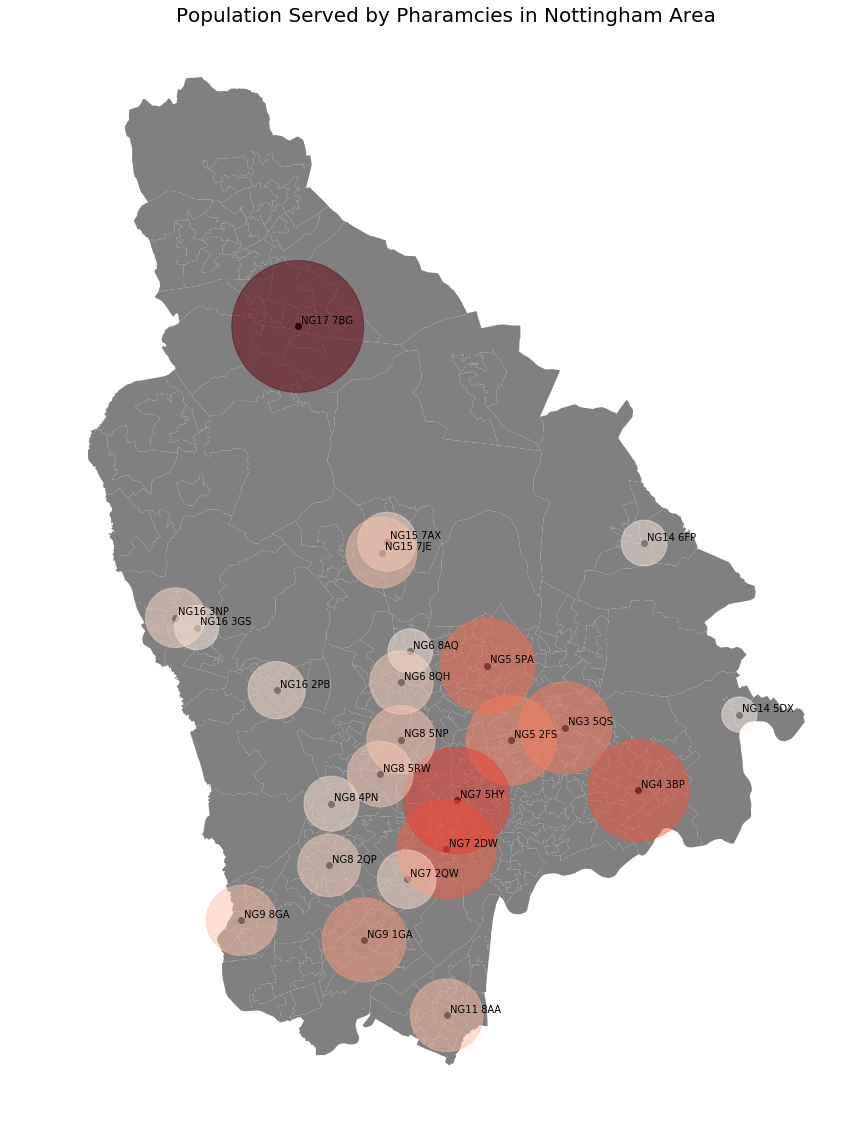

In [35]:
fig, ax = plt.subplots(figsize=(15,20))
notts_geo_data.plot(ax=ax, facecolor='grey')
geo_pharmacy_data.plot(ax=ax, c='black')
geo_pharmacy_data.plot(ax=ax, column="Population", s = geo_pharmacy_data['Population']/5, alpha=0.5, cmap='Reds')
for x, y, label in zip(geo_pharmacy_data.geometry.x, geo_pharmacy_data.geometry.y, geo_pharmacy_data['Nearest_Pharmacy']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
plt.axis('off')
plt.grid(b=None)
plt.title('Population Served by Pharamcies in Nottingham Area', fontsize = 20)
plt.show()

In this plot the size of the bubbles is proportional to the size of the population served by each pharmacy (scaled by 5). We see that there some of our pharmacies have a very large population to support, and some a very small population. 

Interestingly, the proximity of other pharmacies has very little bearing.

We also need to keep in mind that since we're only using a small area of the country for our sample analysis, there might be pharmacies just outside our range which would alter these results.

## Demographic Risk Analysis

It's not necessarily enough for us just to understand the volume of potential customers to each pharmacy when we consider how to plan vaccine distribution. Not everyone is equally at risk of contracting, or dying, from the disease and it would remiss of us not to try and target/prioritise those demographic groups that are more at risk.

What we will seek to do now if to identify the LSOAs within the Nottingham area which contain a larger, or smaller, number of high risk persons, so that these areas could be given extra support if necessary.

### The Plan

Many studies have been conducted attempting to uncover links between demographics and mortality rates in relation to covid-19. For the purposes of this case study, where our main aim is to formulate a methodology rather than to create an infallible model for covid-19 risk, we will focus on three demographic factors which have been widely reported as having some effect on covid-19 mortality rate. Namely:

- Age
- Deprivation
- Ethnicity

Of course, this is not an exhaustive list of factors. For example, one of the most significant variables which we are not exploring in this notebook related to covid-19 mortality is sex/gender, with males much more likely to die of the disease than females. 

It's also worth noting that there may be significant overlap between the factors we have chosen (it has been suggested that deprivation and low-income may be one of the main driving factors behind the difference in covid-19 rates for certain ethnic groups). However, for the purposes of demonstrating our method these factors will suffice for now.

### Age 

#### The Data

In [36]:
with urllib.request.urlopen("https://iqapi.azurewebsites.net/api/UkAgeBylandLsoa") as url:
    data = json.loads(url.read().decode())
age_data = pd.DataFrame(data['results'])

In [39]:
age_data = age_data.drop(['LA__2019_boundaries_'], axis=1).dropna()
age_data.head()

,LSOA,Area_Codes,All_Ages,C0,C1,C2,C3,C4,C5,C6,...,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90_
1,County Durham 001A,E01020634,1665,22,12,14,16,17,22,19,...,17,7,5,11,4,8,3,3,7,9
2,County Durham 001B,E01020635,1364,19,13,13,27,11,17,11,...,8,8,7,3,8,5,6,5,7,8
3,County Durham 001C,E01020636,1730,18,21,10,22,20,19,27,...,13,8,13,6,5,9,4,3,3,15
4,County Durham 001D,E01020654,1830,11,13,20,16,21,15,21,...,9,18,9,8,10,17,10,11,10,37
5,County Durham 001E,E01020676,1510,17,9,11,16,17,16,17,...,4,8,2,3,6,3,4,3,0,2


You may recognise this data, as we used it previously when calculating the populations served by each pharmacy. Now we will be using the other part of the table which gives a breakdown of the population for each LSOA by age.

We've removed the Local Authority columns as we won't be using those in our analysis.

#### Analysis

Let's assume that the mandate which we are given asks for us to prioritise over-65s for the first round of vaccinations. What we'll do, therefore, is assign each LSOA in the Nottingham area a rank based on the percentage of its residency which is over-65 (including those who are 65).

We could easily substitute a different approach, here are a couple of alternatives:

- We could rank the LSOAs based on their median age 
- We could use statistical tests to determine the difference between the age distribution of each LSOA and the UK average

As it is we'll stick to looking at over-65 percentage, which we'll calculate now.

In [42]:
indx = age_data.columns[68:].values
age_data['65+'] = age_data[indx].sum(axis=1)
age_data['65+ Percentage'] = age_data['65+']/age_data['All_Ages']
age_data.head()

,LSOA,Area_Codes,All_Ages,C0,C1,C2,C3,C4,C5,C6,...,C83,C84,C85,C86,C87,C88,C89,C90_,65+,65+ Percentage
1,County Durham 001A,E01020634,1665,22,12,14,16,17,22,19,...,5,11,4,8,3,3,7,9,754,0.452853
2,County Durham 001B,E01020635,1364,19,13,13,27,11,17,11,...,7,3,8,5,6,5,7,8,622,0.456012
3,County Durham 001C,E01020636,1730,18,21,10,22,20,19,27,...,13,6,5,9,4,3,3,15,698,0.403468
4,County Durham 001D,E01020654,1830,11,13,20,16,21,15,21,...,9,8,10,17,10,11,10,37,818,0.446995
5,County Durham 001E,E01020676,1510,17,9,11,16,17,16,17,...,2,3,6,3,4,3,0,2,642,0.425166


Again we're only really interested in the Nottingham based LSOAs. We'll rank them relative to the Nottingham area, rather than nationally.

Rank 1 will correspond to the largest over-65 percentage, with Rank 404 having the smallest over-65 percentage

In [43]:
notts_age_data = age_data[age_data['LSOA'].str.contains('Nottingham|Ashfield|Gedling|Broxtowe')]

In [44]:
notts_age_data['Age Rank'] = notts_age_data['65+ Percentage'].rank(ascending=False)

Here are the five LSOAs with the largest over-65 population percentage

In [45]:
notts_age_data.sort_values('Age Rank').head()

,LSOA,Area_Codes,All_Ages,C0,C1,C2,C3,C4,C5,C6,...,C84,C85,C86,C87,C88,C89,C90_,65+,65+ Percentage,Age Rank
12074,Gedling 001C,E01028199,1479,8,13,15,12,19,11,6,...,16,16,15,10,1,9,22,1190,0.804598,1.0
12013,Broxtowe 003E,E01028118,1706,9,11,8,9,10,16,6,...,22,12,17,9,11,4,10,1334,0.781946,2.0
11912,Ashfield 013E,E01027936,1417,14,12,12,14,13,12,17,...,15,6,3,5,5,4,14,1066,0.752294,3.0
9931,Nottingham 010B,E01013968,1403,10,9,8,11,8,18,15,...,18,10,15,6,8,10,88,1022,0.728439,4.0
12100,Gedling 007E,E01028183,1227,6,8,8,17,10,15,14,...,18,11,4,3,6,4,3,886,0.722086,5.0


Here are the five LSOAs with the smallest over-65 population percentage

In [46]:
notts_age_data.sort_values('Age Rank').tail()

,LSOA,Area_Codes,All_Ages,C0,C1,C2,C3,C4,C5,C6,...,C84,C85,C86,C87,C88,C89,C90_,65+,65+ Percentage,Age Rank
10018,Nottingham 028G,E01033404,3800,12,20,22,19,19,14,14,...,1,0,0,0,1,0,6,132,0.034737,400.0
10063,Nottingham 039C,E01033402,1858,5,5,6,10,5,6,4,...,1,0,0,0,0,0,3,58,0.031216,401.0
10009,Nottingham 026F,E01013953,2935,13,8,9,10,15,13,11,...,2,1,1,1,0,1,2,84,0.028620,402.0
10010,Nottingham 026G,E01033395,3459,10,10,8,4,7,8,6,...,2,0,0,0,1,0,2,56,0.016190,403.0
10065,Nottingham 039E,E01033406,2042,5,8,3,2,3,1,2,...,0,0,0,0,0,0,2,32,0.015671,404.0


We will come back to this age ranking later on when we combine our risk factors.

### Deprivation

#### The Data

Again this data can be sourced from our database

In [47]:
with urllib.request.urlopen("https://iqapi.azurewebsites.net/api/UKIMDBYLSOA") as url:
    data = json.loads(url.read().decode())
imd_data = pd.DataFrame(data['results'])

In [48]:
imd_data.head()

,LSOA_code_2011,LSOA_name_2011,Local_Authority_District_code_2019,Local_Authority_District_name_2019,Index_of_Multiple_Deprivation_IMD_Score,Index_of_Multiple_Deprivation_IMD_Rank_where_1_is_most_deprived,Index_of_Multiple_Deprivation_IMD_Decile_where_1_is_most_deprived_10_of_LSOAs,Income_Score_rate,Income_Rank_where_1_is_most_deprived,Income_Decile_where_1_is_most_deprived_10_of_LSOAs,...,Indoors_Sub_domain_Rank_where_1_is_most_deprived,Indoors_Sub_domain_Decile_where_1_is_most_deprived_10_of_LSOAs,Outdoors_Sub_domain_Score,Outdoors_Sub_domain_Rank_where_1_is_most_deprived,Outdoors_Sub_domain_Decile_where_1_is_most_deprived_10_of_LSOAs,Total_population_mid_2015_excluding_prisoners,Dependent_Children_aged_0_15_mid_2015_excluding_prisoners,Population_aged_16_59_mid_2015_excluding_prisoners,Older_population_aged_60_and_over_mid_2015_excluding_prisoners,Working_age_population_18_59_64_for_use_with_Employment_Deprivation_Domain_excluding_prisoners
0,E01000001,City of London 001A,E09000001,City of London,6.208,29199,9,0.007,32831,10,...,16364,5,1.503,1615,1,1296,175,656,465,715
1,E01000002,City of London 001B,E09000001,City of London,5.143,30379,10,0.034,29901,10,...,22676,7,1.196,2969,1,1156,182,580,394,620
2,E01000003,City of London 001C,E09000001,City of London,19.402,14915,5,0.086,18510,6,...,17318,6,2.207,162,1,1350,146,759,445,804
3,E01000005,City of London 001E,E09000001,City of London,28.652,8678,3,0.211,6029,2,...,25218,8,1.769,849,1,1121,229,692,200,683
4,E01000006,Barking and Dagenham 016A,E09000002,Barking and Dagenham,19.837,14486,5,0.117,14023,5,...,14745,5,0.969,4368,2,2040,522,1297,221,1285


This data contains information regarding the Index of Multiple Deprivation (IMD) for all the LSOAs in England and Wales. The IMD is a measure of relative deprivation between areas, as is calculated using the other variables in the table (income levels/crime/health etc).

#### Analysis

We'll filter out the Nottingham LSOAs again, and assign each of them a deprivation rank.

Fortunately for us, the IMD scores have already been calculated, so it will be very straightforward to rank the LSOAs in Nottingham from most deprived (Rank 1) to least deprived (Rank 404)

In [50]:
notts_imd_data = imd_data[imd_data['LSOA_name_2011'].str.contains('Nottingham|Ashfield|Gedling|Broxtowe')]

In [52]:
notts_imd_data['IMD Rank'] = notts_imd_data['Index_of_Multiple_Deprivation_IMD_Score'].rank(ascending=False)

Here are the top five most deprived LSOAs 

In [53]:
notts_imd_data.sort_values('IMD Rank').head()

,LSOA_code_2011,LSOA_name_2011,Local_Authority_District_code_2019,Local_Authority_District_name_2019,Index_of_Multiple_Deprivation_IMD_Score,Index_of_Multiple_Deprivation_IMD_Rank_where_1_is_most_deprived,Index_of_Multiple_Deprivation_IMD_Decile_where_1_is_most_deprived_10_of_LSOAs,Income_Score_rate,Income_Rank_where_1_is_most_deprived,Income_Decile_where_1_is_most_deprived_10_of_LSOAs,...,Indoors_Sub_domain_Decile_where_1_is_most_deprived_10_of_LSOAs,Outdoors_Sub_domain_Score,Outdoors_Sub_domain_Rank_where_1_is_most_deprived,Outdoors_Sub_domain_Decile_where_1_is_most_deprived_10_of_LSOAs,Total_population_mid_2015_excluding_prisoners,Dependent_Children_aged_0_15_mid_2015_excluding_prisoners,Population_aged_16_59_mid_2015_excluding_prisoners,Older_population_aged_60_and_over_mid_2015_excluding_prisoners,Working_age_population_18_59_64_for_use_with_Employment_Deprivation_Domain_excluding_prisoners,IMD Rank
13460,E01013877,Nottingham 005C,E06000018,Nottingham,73.881,130,1,0.448,142,1,...,7,1.038,3889,2,1477,406,846,225,836,1.0
13445,E01013861,Nottingham 020B,E06000018,Nottingham,73.321,145,1,0.455,124,1,...,9,0.766,5919,2,1515,296,747,472,761,2.0
13526,E01013948,Nottingham 026E,E06000018,Nottingham,71.684,207,1,0.466,100,1,...,9,1.524,1537,1,1211,174,871,166,918,3.0
13404,E01013818,Nottingham 011B,E06000018,Nottingham,70.390,265,1,0.470,91,1,...,5,0.711,6396,2,1802,628,1017,157,981,4.0
27259,E01027974,Ashfield 005D,E07000170,Ashfield,66.426,438,1,0.390,493,1,...,8,-0.128,17477,6,1607,396,994,217,975,5.0


And here are the five least deprived

In [54]:
notts_imd_data.sort_values('IMD Rank').tail()

,LSOA_code_2011,LSOA_name_2011,Local_Authority_District_code_2019,Local_Authority_District_name_2019,Index_of_Multiple_Deprivation_IMD_Score,Index_of_Multiple_Deprivation_IMD_Rank_where_1_is_most_deprived,Index_of_Multiple_Deprivation_IMD_Decile_where_1_is_most_deprived_10_of_LSOAs,Income_Score_rate,Income_Rank_where_1_is_most_deprived,Income_Decile_where_1_is_most_deprived_10_of_LSOAs,...,Indoors_Sub_domain_Decile_where_1_is_most_deprived_10_of_LSOAs,Outdoors_Sub_domain_Score,Outdoors_Sub_domain_Rank_where_1_is_most_deprived,Outdoors_Sub_domain_Decile_where_1_is_most_deprived_10_of_LSOAs,Total_population_mid_2015_excluding_prisoners,Dependent_Children_aged_0_15_mid_2015_excluding_prisoners,Population_aged_16_59_mid_2015_excluding_prisoners,Older_population_aged_60_and_over_mid_2015_excluding_prisoners,Working_age_population_18_59_64_for_use_with_Employment_Deprivation_Domain_excluding_prisoners,IMD Rank
27419,E01028136,Broxtowe 015B,E07000172,Broxtowe,3.086,32182,10,0.023,31925,10,...,9,0.057,14378,5,1732,341,944,447,927,400.0
27496,E01028216,Gedling 009E,E07000173,Gedling,2.831,32321,10,0.028,31161,10,...,7,0.021,14944,5,1304,219,682,403,690,401.0
27481,E01028201,Gedling 001E,E07000173,Gedling,2.773,32349,10,0.027,31257,10,...,10,-0.618,25152,8,1153,184,518,451,545,402.0
27422,E01028139,Broxtowe 015E,E07000172,Broxtowe,2.767,32353,10,0.030,30825,10,...,10,0.084,13917,5,1430,261,853,316,859,403.0
27420,E01028137,Broxtowe 015C,E07000172,Broxtowe,2.039,32653,10,0.029,31043,10,...,10,-0.115,17271,6,2544,528,1739,277,1686,404.0


We will use these IMD rankings later on when we create our prioritisation metric.

### Ethnicity

#### The Data

In [84]:
with urllib.request.urlopen("https://iqapi.azurewebsites.net/api/UkEthnicityByLsoa") as url:
    data = json.loads(url.read().decode())
ethnicity_data = pd.DataFrame(data['results'])

In [85]:
ethnicity_data.head()

,date,geography,geography_code,Ethnic_Group__All_categories__Ethnic_group,Ethnic_Group__White__Total,Ethnic_Group__White__English_Welsh_Scottish_Northern_Irish_British,Ethnic_Group__White__Irish,Ethnic_Group__White__Gypsy_or_Irish_Traveller,Ethnic_Group__White__Other_White,Ethnic_Group__Mixed_multiple_ethnic_group__Total,...,Ethnic_Group__Asian_Asian_British__Bangladeshi,Ethnic_Group__Asian_Asian_British__Chinese,Ethnic_Group__Asian_Asian_British__Other_Asian,Ethnic_Group__Black_African_Caribbean_Black_British__Total,Ethnic_Group__Black_African_Caribbean_Black_British__African,Ethnic_Group__Black_African_Caribbean_Black_British__Caribbean,Ethnic_Group__Black_African_Caribbean_Black_British__Other_Black,Ethnic_Group__Other_ethnic_group__Total,Ethnic_Group__Other_ethnic_group__Arab,Ethnic_Group__Other_ethnic_group__Any_other_ethnic_group
0,2011,Darlington 001B,E01012334,2466,2404,2374,9,3,18,29,...,0,5,1,1,0,1,0,5,1,4
1,2011,Darlington 001C,E01012335,1383,1362,1355,2,0,5,9,...,5,3,3,0,0,0,0,1,1,0
2,2011,Darlington 001D,E01012366,2008,1966,1938,4,5,19,16,...,1,1,9,6,1,1,4,0,0,0
3,2011,Darlington 001E,E01033481,1364,1316,1294,3,5,14,16,...,0,5,3,6,4,2,0,4,4,0
4,2011,Darlington 001F,E01033482,1621,1566,1534,0,26,6,20,...,0,6,3,11,10,0,1,1,1,0


This is a very rich dataset, which gives a breakdown of the different ethnic groups present in each LSOA.

The only issue we have is that this data is from 2011, and it can be reasonably assumed that things have significantly changed in some LSOAs since then. We also have to bear in mind that the population numbers for each LSOA (all categories ethnic group) will not match up with the more up to date numbers we have been using in the other sections of this notebook. With that said, most of the numbers and ratios should be similar.

It should also be noted that this data only contains info from England/Wales, which may skew our UK averages slightly.

#### Analysis

This is the most complicated (and perhaps controversial) factor that we are going to explore. There are a great many different ethnic groups present within the UK (and indeed within Nottingham) who may be more or less likely to contract or die from covid-19 (ignoring the underlying factors which may explain the discrepancies). 

A lot of research has been done in this space in an attempt to identify the ethnic groups that at most at risk, and the general consensus is that persons from a BAME background are more at risk than those who aren't. Of course, this is a gross oversimplification, ignoring the differences in risk of groups within those categorised as BAME (as well as those that aren't). 

What we're going to do in our analysis is to rank each LSOA based the significant difference in its BAME population when compared to the national average. With the most significantly BAME LSOA being assigned Rank 1 and the least significantly BAME LSOA being assigned rank 404. 

We do this on the understanding that the aim of this notebook is to demonstrate a process rather than to determine an actual prioritisation model. If we were to use this method (or one similar) to identify those LSOAs with the highest risk demographic factors, we would need to be more specific about the groups that were targeted based on the current understanding of how ethnicity effects covid-19 risk.

Therefore, the first thing we need to do is work out the distributions of BAME persons in the UK and each of the LSOAs that we're interested in.

In [58]:
ethnicity_data.drop(['date', 'geography_code'], axis=1, inplace=True)
ethnicity_data = ethnicity_data.set_index('geography')
ethnicity_data.loc['UK'] = ethnicity_data.sum()

ethnicity_data['White'] = ethnicity_data['Ethnic_Group__White__Total']
ethnicity_data['BAME'] = ethnicity_data['Ethnic_Group__All_categories__Ethnic_group']-ethnicity_data['White']

ethnicity_data = ethnicity_data[['BAME', 'White']].reset_index()

In [59]:
ethnicity_data.tail()

,geography,BAME,White
34749,Newport 020C,63,1402
34750,Newport 020D,82,1803
34751,Newport 020E,80,1400
34752,Newport 020F,142,1298
34753,UK,7866517,48209395


Now what we'll do is use the Chi-Square test to compare each LSOA to the UK average. We will be returned a statistical value and p-value for each LSOA to determine whether or not the LSOA's BAME is significantly different to the UK average, and by how much.

Unfortunately, we won't know in which direction the significance lies. To determine this we will compare the BAME percentage of each LSOA to the Uk average.

In [60]:
notts_ethnicity_data = ethnicity_data[ethnicity_data['geography'].str.contains('Nottingham|Ashfield|Gedling|Broxtowe')]
uk_ethnicity = ethnicity_data[ethnicity_data['geography'] == 'UK'][['BAME', 'White']].values[0]

In [61]:
p_list = []
stat_list = []

for index, row in notts_ethnicity_data.iterrows():

    test = row[['BAME', 'White']].values
    data = {'expected':uk_ethnicity, 'observed':test}
    df = pd.DataFrame(data)
    chi2, p, dof, exp=cont.chi2_contingency(df)
    p_list.append(p)
    stat_list.append(chi2)  
    
notts_ethnicity_data['ethnicity stat value'] = stat_list
notts_ethnicity_data['ethnicity p-value'] = p_list

notts_ethnicity_data['BAME Percentage'] = notts_ethnicity_data['BAME']/(notts_ethnicity_data['White']+notts_ethnicity_data['BAME'])
uk_average = uk_ethnicity[0]/(uk_ethnicity[0]+uk_ethnicity[1])

In [62]:
notts_ethnicity_data.head()

,geography,BAME,White,ethnicity stat value,ethnicity p-value,BAME Percentage
9814,Nottingham 001A,313,1221,51.176426,8.442645e-13,0.204042
9815,Nottingham 001B,278,1136,36.724777,1.360394e-09,0.196605
9816,Nottingham 001C,343,1006,144.362329,2.960559e-33,0.254262
9817,Nottingham 001D,238,1238,5.205695,2.251301e-02,0.161247
9818,Nottingham 002A,186,1107,0.108512,7.418450e-01,0.143852


Now we have all the information we need to rank these LSOA based on their BAME population significance.

In [63]:
new_values = []
for index, row in notts_ethnicity_data.iterrows():
    if row['BAME Percentage'] < uk_average:
        new_values.append(-row['ethnicity stat value'])
    else:
        new_values.append(row['ethnicity stat value'])
        
notts_ethnicity_data['new stat value'] = new_values
notts_ethnicity_data['BAME Rank'] = notts_ethnicity_data['new stat value'].rank (ascending=False)

Here are the five LSOAs in Nottingham with the most significant BAME populations

In [64]:
notts_ethnicity_data.sort_values('BAME Rank').head()

,geography,BAME,White,ethnicity stat value,ethnicity p-value,BAME Percentage,new stat value,BAME Rank
9935,Nottingham 026G,1288,884,3686.810059,0.0,0.593002,3686.810059,1.0
9897,Nottingham 019A,1163,817,3277.535412,0.0,0.587374,3277.535412,2.0
9892,Nottingham 018A,1024,633,3130.941843,0.0,0.617984,3130.941843,3.0
9894,Nottingham 018C,1004,620,3071.631064,0.0,0.618227,3071.631064,4.0
9890,Nottingham 017C,1004,684,2887.157006,0.0,0.594787,2887.157006,5.0


And here are the five with the least significant.

In [65]:
notts_ethnicity_data.sort_values('BAME Rank').tail()

,geography,BAME,White,ethnicity stat value,ethnicity p-value,BAME Percentage,new stat value,BAME Rank
11795,Ashfield 011B,23,1826,249.513949,3.314390e-56,0.012439,-249.513949,400.0
11761,Ashfield 004B,54,2185,249.557011,3.243512e-56,0.024118,-249.557011,401.0
11962,Broxtowe 016G,47,2157,257.619035,5.669158e-58,0.021325,-257.619035,402.0
11791,Ashfield 010B,33,2004,259.018299,2.808698e-58,0.016200,-259.018299,403.0
11797,Ashfield 011D,11,1746,260.566055,1.291607e-58,0.006261,-260.566055,404.0


Now that we've explored each of our three factors, we can think about assigning each LSOA a risk factor.

### Risk Prioritisation 

We have ranked each of our LSOAs based on age, deprivation and BAME population significance. Now we would like to collate these three factors into a single indicator which will determine the overall demographic risk to each LSOA with a mind to prioritsation of vaccine distribution.

Not all of the factors we have discussed are equally valuable in determining covid-19 risk, therefore we will assign them each a weight when we create our risk coefficient. Since we don't actually know the value of each factor, or what government/pharmaceutical policy will be in terms of prioritisation, we will simply create our own.

We will assume the following priority/weighting:

- Oldest Areas get highest priority (coefficient of 1)
- Poorest Areas get next priority (coefficient of 0.75)
- High BAME Areas get next priority (coefficient of 0.5)

The equation we will use to obtian our risk coefficient will therefore be:

                                Age + 0.75 Deprivation + 0.5 BAME Significance

We could easily change these weightings if we wanted to, or remove certain factors entirely from consideration. 

#### The Data

We have already created all the data that we will need, all we have to do is join the relevant columns together.

In [66]:
risk_data = notts_age_data[['Area_Codes', 'LSOA', 'Age Rank']].merge(notts_imd_data[['LSOA_code_2011', 'IMD Rank']],
                                                                    left_on = 'Area_Codes', right_on = 'LSOA_code_2011',
                                                                    how='left').drop('LSOA_code_2011', axis=1)

In [67]:
risk_data = risk_data.merge(notts_ethnicity_data[['geography', 'BAME Rank']], left_on = 'LSOA', 
                            right_on='geography').drop('geography', axis=1)

In [68]:
risk_data.head()

,Area_Codes,LSOA,Age Rank,IMD Rank,BAME Rank
0,E01013887,Nottingham 001A,25.0,285.0,125.0
1,E01013892,Nottingham 001B,14.0,288.0,132.0
2,E01013893,Nottingham 001C,339.0,95.0,102.0
3,E01013894,Nottingham 001D,33.0,248.0,148.0
4,E01013879,Nottingham 002A,285.0,9.0,163.0


#### Analysis

Now we'll apply our equation to obtain a risk coefficient for each LSOA. We'll also assign a risk rank with 1 being the highest risk area and 404 being the lowest risk area.

In [69]:
risk_data['Priority Coefficient'] = risk_data['Age Rank'] + 0.75*risk_data['IMD Rank'] + 0.5*risk_data['BAME Rank']
risk_data['Risk Rank'] = risk_data['Priority Coefficient'].rank()

Let's look at the ten highest risk LSOAs

In [70]:
risk_data.sort_values('Risk Rank').head(10)

,Area_Codes,LSOA,Age Rank,IMD Rank,BAME Rank,Priority Coefficient,Risk Rank
88,E01013859,Nottingham 020A,38.0,38.0,176.0,154.50,1.0
89,E01013861,Nottingham 020B,83.0,2.0,177.0,173.00,2.0
90,E01013868,Nottingham 020C,101.0,22.0,160.0,197.50,3.0
160,E01013908,Nottingham 036B,30.0,96.0,215.0,209.50,4.0
113,E01013860,Nottingham 025B,109.0,37.0,159.0,216.25,5.0
171,E01032621,Nottingham 038E,79.0,63.0,185.0,218.75,6.0
179,E01013871,Nottingham 040B,180.0,29.0,36.0,219.75,7.0
161,E01013909,Nottingham 036C,152.0,25.0,206.0,273.75,8.0
168,E01013850,Nottingham 038B,156.0,43.0,174.0,275.25,9.0
169,E01013851,Nottingham 038C,214.0,10.0,110.0,276.50,10.0


And the ten lowest

In [71]:
risk_data.sort_values('Risk Rank').tail(10)

,Area_Codes,LSOA,Age Rank,IMD Rank,BAME Rank,Priority Coefficient,Risk Rank
127,E01032520,Nottingham 028E,311.0,356.0,123.0,639.50,395.0
120,E01013953,Nottingham 026F,402.0,303.0,33.0,645.75,396.0
298,E01028075,Broxtowe 011C,344.0,301.0,164.0,651.75,397.0
399,E01028188,Gedling 015E,327.0,278.0,241.0,656.00,398.0
268,E01028117,Broxtowe 003D,236.0,371.0,338.0,683.25,399.0
336,E01028154,Gedling 002E,270.0,302.0,381.0,687.00,400.0
247,E01027938,Ashfield 015B,240.0,366.0,360.0,694.50,401.0
223,E01027959,Ashfield 009E,298.0,338.0,309.0,706.00,402.0
317,E01028137,Broxtowe 015C,322.0,404.0,202.0,726.00,403.0
209,E01027992,Ashfield 006F,308.0,391.0,377.0,789.75,404.0


Interestingly we see that despite IMD being given a 0.75 modifier, it seems to be more highly influential in determining the risk of an LSOA than the other two metrics according to our system. This may be because the oldest LSOAs are more likely to be less deprived and have a lower percentage of BAME persons, which compensates for their elderly population. 

What we want to do now if look at the map of the Nottingham area again and see where the high risk areas in relation to each other. By the looks of our results it seems as if most of the high risk areas are clusterd around the city itself, with the low risk areas in the suburbs and surrounding countryside. This is in line with what we would expect and lends credence to our model.

### Visualisation

We'll use goepandas again to create a plot of the LSOAs, and colour code them based on their risk coefficient.

#### The Data

In [72]:
geo_data = geopandas.read_file('LSOA_2011_EW_BFC_shp/LSOA_2011_EW_BFC.shx')
nott_geo_data = geo_data[geo_data['LSOA11NM'].str.contains('Nottingham|Ashfield|Gedling|Broxtowe')]
nott_geo_data.head()

,LSOA11CD,LSOA11NM,geometry
55,E01028069,Broxtowe 014A,"POLYGON ((452416.063 335233.071, 452410.331 33..."
555,E01028206,Gedling 004C,"POLYGON ((458994.342 345935.881, 458987.045 34..."
560,E01028207,Gedling 004D,"POLYGON ((459110.078 346615.682, 459099.789 34..."
563,E01028204,Gedling 010F,"POLYGON ((460549.046 342952.104, 460542.485 34..."
565,E01028205,Gedling 004B,"POLYGON ((458582.634 346395.981, 458576.794 34..."


We'll load in the shapefile data again (although we really don't need to).

We'll add the risk coefficients as a column of this table

In [75]:
notts_risk_plot_data = nott_geo_data.merge(risk_data[['Area_Codes', 'Priority Coefficient']], 
                                    left_on = 'LSOA11CD', right_on = 'Area_Codes', how='left').drop('Area_Codes', axis=1)

In [76]:
notts_risk_plot_data.head()

,LSOA11CD,LSOA11NM,geometry,Priority Coefficient
0,E01028069,Broxtowe 014A,"POLYGON ((452416.063 335233.071, 452410.331 33...",549.25
1,E01028206,Gedling 004C,"POLYGON ((458994.342 345935.881, 458987.045 34...",503.25
2,E01028207,Gedling 004D,"POLYGON ((459110.078 346615.682, 459099.789 34...",443.75
3,E01028204,Gedling 010F,"POLYGON ((460549.046 342952.104, 460542.485 34...",458.50
4,E01028205,Gedling 004B,"POLYGON ((458582.634 346395.981, 458576.794 34...",560.25


Now we have everything we need to create our plot.

#### Base Plot

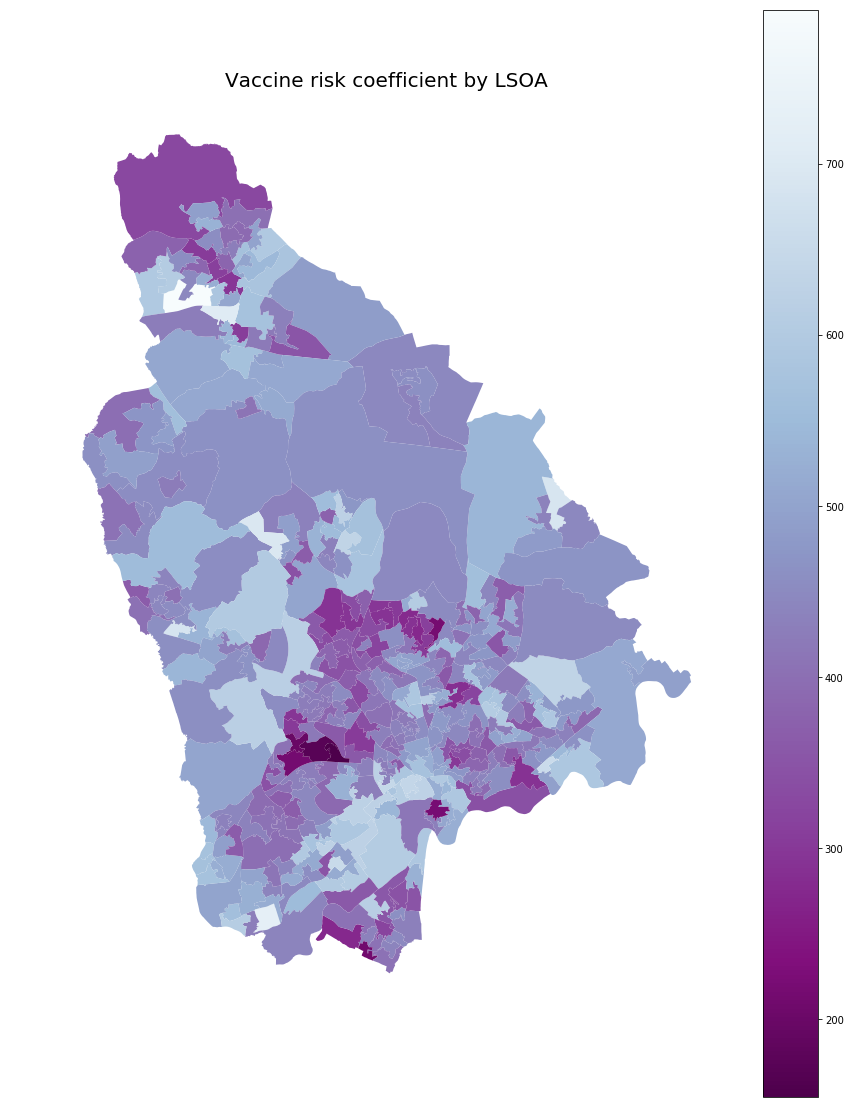

In [77]:
fig, ax = plt.subplots(figsize=(15,20))
notts_risk_plot_data.plot(ax=ax, column="Priority Coefficient", legend=True, cmap='BuPu_r')
plt.axis('off')
plt.grid(b=None)
plt.title('Vaccine risk coefficient by LSOA', fontsize = 20)
plt.show()

The darker areas represent high risk LSOAs and the lighter areas low risk LSOAs. We can see that, as we suspected, most of the high risk areas are in the city itself. However, we notice there are a few LSOAs on the outskirts of our sampled area that are also fairly high risk, most likely due to an elderly population. 

#### Combined Plot

Another that we'll do is overlay the locations of the pharmacies and their population served over the risk plot, so we can get an overall picture of the situation in the Nottingham area. 

We will be able to identify which of our pharmacies are supplying the high risk areas.

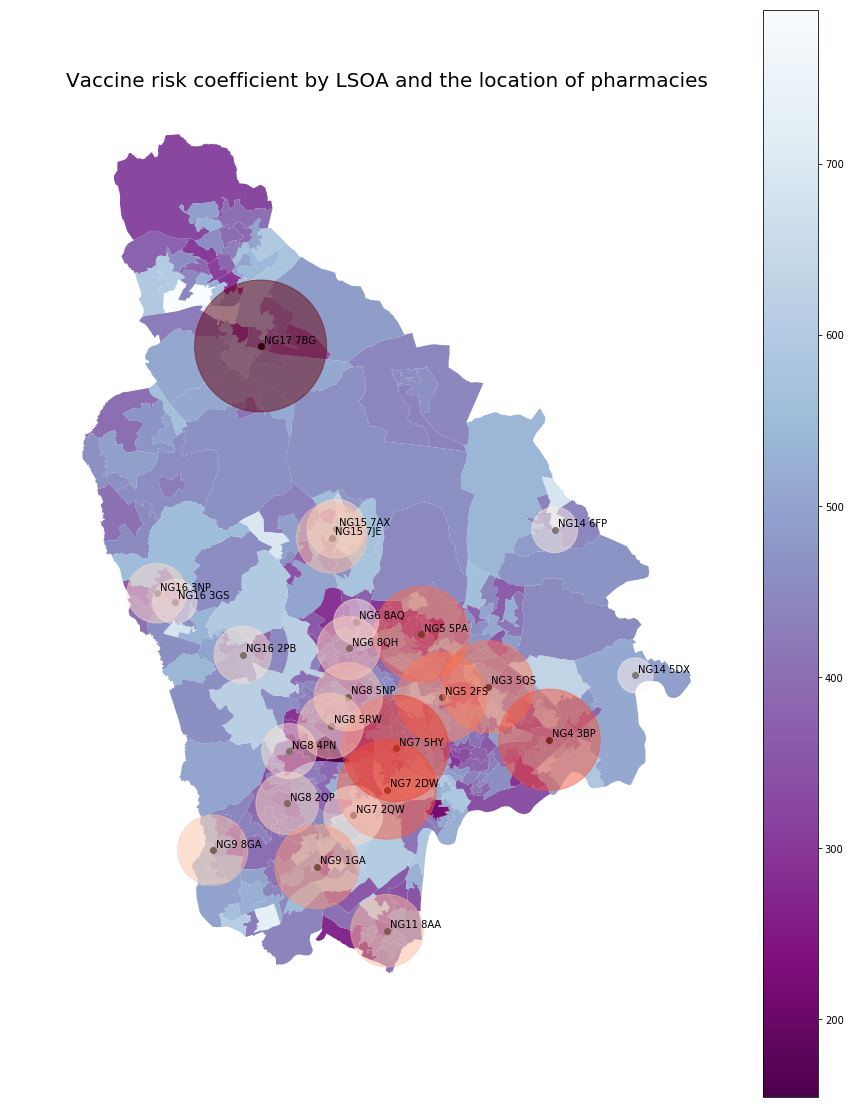

In [78]:
fig, ax = plt.subplots(figsize=(15,20))
notts_risk_plot_data.plot(ax=ax, column="Priority Coefficient", legend=True, cmap='BuPu_r')
geo_pharmacy_data.plot(ax=ax, c='black')
geo_pharmacy_data.plot(ax=ax, column="Population", s = geo_pharmacy_data['Population']/5, alpha=0.5, cmap='Reds')
for x, y, label in zip(geo_pharmacy_data.geometry.x, geo_pharmacy_data.geometry.y, geo_pharmacy_data['Nearest_Pharmacy']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
plt.axis('off')
plt.grid(b=None)
plt.title('Vaccine risk coefficient by LSOA and the location of pharmacies', fontsize = 20)
plt.show()

This plot is a bit difficult to decipher due to the close proximity of certain pharmacies, but we can see that, for example, the pharmacy at NG17 7GB would be in need of extra attention because not only is it serving a large population but many of its nearest LSOAs are high risk. Conversely, the pharmacy at NG14 5DX is serving a small population and is surrounded by low risk LSOAs. 

## Final Thoughts

We have devised a method of determining the potential populations served by each pharmacy in our sample as well as identifying the most at risk LSOAs. Combining these two pieces of analysis we are able to better understand the demographic layout of Nottingham and where vaccine distribution might be prioritised.

Theoretically, if we were given more concrete guidelines on which demographic groups were eligible for prioritsiation, and we knew how many vaccines we had available for distribution, we could use similar methodology to give a numerical estimate of how many vaccines to send to each pharmacy. 

Here below is a table summarising the population served by and average demographic LSOA risk coefficients of each pharmacy in our sample.

In [86]:
pharma_summary = risk_data.merge(lsoa_notts[['Area_Codes', 'Nearest_Pharmacy', 'All_Ages']], on='Area_Codes', how='left')

In [89]:
pharma_summary_groups = pharma_summary.groupby('Nearest_Pharmacy').agg({
    'Age Rank':'mean',
    'IMD Rank':'mean',
    'BAME Rank':'mean',
    'Priority Coefficient':'mean',
    'Risk Rank':'mean',
    'All_Ages':'sum'
}).rename(columns={'All_Ages': 'Total Population'})

In [90]:
pharma_summary_groups.sort_values('Priority Coefficient')

,Age Rank,IMD Rank,BAME Rank,Priority Coefficient,Risk Rank,Total Population
Nearest_Pharmacy,,,,,,
NG6 8AQ,159.714286,100.142857,164.714286,317.178571,29.857143,10079
NG8 5RW,258.916667,69.750000,93.916667,358.187500,93.875000,21435
NG8 4PN,174.444444,136.666667,164.333333,359.111111,107.166667,15179
NG6 8QH,222.384615,95.846154,151.846154,370.192308,76.615385,20137
NG11 8AA,189.941176,139.147059,209.176471,398.889706,130.588235,26443
NG8 2QP,105.923077,308.615385,130.230769,402.500000,114.923077,19673
NG8 5NP,240.461538,150.769231,105.615385,406.346154,129.846154,23392
NG5 5PA,205.758621,169.206897,180.482759,422.905172,173.672414,45451
NG5 2FS,276.043478,157.739130,93.260870,440.978261,183.152174,40292
